# Mapping CG PMFs onto the Continuum Model
In this notebook, we show how to predict the parameters of the CG model yielding a given combination of free energy maxima and minima for neutral and charged amino acids.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os, sys, json, shutil
from math import asinh, sqrt, pi
import pandas as pd
import glob
import mdtraj as md
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from mpl_toolkits.axes_grid1 import make_axes_locatable
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings('ignore')
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/giulio/Repos/SI-peptidebilayer


### Parametrized Expressions of Free Energy Values for Amino Acids at the Midplane and at the Interface

In [16]:
def min0(aa,ah,at,x):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*aa*x**3*Rl**3/2.
    s=.0175*ah
    I1= 1.15*3*(b+s)/b**4 - 1.15*3./(b+s)**3 + 3*h/(b+s)**4
    I2= 3*(b+s-h)/(b+s)**4 + 1./(b+s)**3 - 1./(t+h)**3
    I3= 1./(t+h)**3 - 1./(t+2*h)**3
    return C*(ah*I1+at*I2+ah*I3)+0.5*2*pi*(x+s-h)*(x+s)
def max0(aa,ah,at,x):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*aa*x**3*Rl**3/2.
    I1=4./b**3 - 8./t**3 
    I2=8./t**3 - 1./(t/2.+h)**3 
    return C*(3.36*at*I1+ah*I2)+6.2*4*np.pi*(x+0.084)**2
def min1(aa,ah,at,x):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*Rl**3*.71/2.
    s=0.057*ah
    I1= 0.927*(b+s)/b/b - 0.927*1./(b+s) + h/(b+s)**2
    I2= (b+s-h)/(b+s)**2 + 1./(b+s) - 1./(t+h)
    I3= 1./(t+h) - 1./(t+2*h)
    return C*(ah*I1+at*I2+ah*I3)+0.5*2*np.pi*(x+s-h)*(x+s)
def max1(aa,ah,at,x):
    t=3.8; h=.5; Rl=.5; b=x+Rl
    C=-pi*Rl**3*.71
    s=0.0093*(ah-at)
    I1= 2./(b+s) - 2./t
    I2= 2./t - 1./(t/2.+h)  
    I3= (b+s)/b/b - 1./(b+s)
    return C*(at*I1+ah*I2+2.27*ah*I3)+6.2*4*np.pi*(s+0.22)**2

In [17]:
def plotting(extr,sub,ahlg=0):
    radii = np.array([1.5,2,2.5,3])/10
    x = np.linspace(.14,.31,100)
    ahs = np.array([25,30,35]); ats = np.array([-30,-35])
    func = min0 if extr=='min0' else min1 if extr=='min1' else max0 if extr=='max0' else max1
    aas = np.array([1]) if extr[-1]=='1' else np.array([1,2])
    for aa in aas:
        mrkr = 'o' if aa==1 else '^'
        cnt = 0
        for ah in ahs:
            for at in ats:
                m = pmfs.loc[ah,at,aa][extr].values
                em = pmfs.loc[ah,at,aa]['E'+extr].values
                params = aa,ah,at
                sub.plot(x*10,func(*params,x),color=colors[cnt],lw=1)
                if ah==ahlg and mrkr=='o':
                    sub.errorbar(radii*10,m,em,lw=0,marker=mrkr,color=colors[cnt],
                        markeredgecolor=None,ms=7,elinewidth=1.,capsize=2,capthick=1.,
                        label=r'$\alpha_h$={:1g}'.format(ah)+r', $\alpha_t$={:1g}'.format(at))
                else:
                    sub.errorbar(radii*10,m,em,lw=0,marker=mrkr,color=colors[cnt],
                        markeredgecolor=None,ms=7,elinewidth=1.,capsize=2,capthick=1.)
                cnt += 1
                if cnt > 9: cnt = 0

In [18]:
if os.path.isfile('pmfs.p'):
    pmfs = pd.read_pickle('pmfs.p')

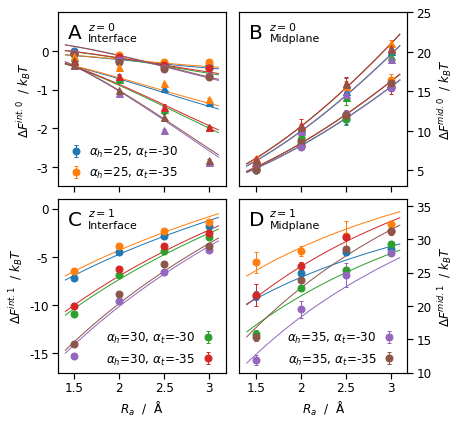

In [19]:
plt.rcParams.update({'figure.figsize': [6.5, 6]})
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
plotting('min0',ax1,25)
plotting('max0',ax2)
plotting('min1',ax3,30)
plotting('max1',ax4,35)
for ax in f.axes:
    ax.set_xticks(np.arange(1.5,3.5,.5))
ax3.set_xticklabels('{:1g}'.format(i) for i in np.arange(1.5,3.5,.5))
ax4.set_xticklabels('{:1g}'.format(i) for i in np.arange(1.5,3.5,.5))
ax1.set_xticklabels(np.tile([''],4))
ax2.set_xticklabels(np.tile([''],4))
ax1.set_ylim(-3.5,1); ax2.set_ylim(3,25)
ax3.set_ylim(-17,1); ax4.set_ylim(10,36)
ax1.set_yticks(np.arange(-3,.5,1)); ax2.set_yticks(np.arange(5,30,5))
ax3.set_yticks(np.arange(-15,1,5)); ax4.set_yticks(np.arange(10,40,5))
ax1.set_yticklabels('{:1g}'.format(i) for i in np.arange(-3,.5,1))
ax2.set_yticklabels('{:1g}'.format(i) for i in np.arange(5,30,5))
ax3.set_yticklabels('{:1g}'.format(i) for i in np.arange(-15,1,5))
ax4.set_yticklabels('{:1g}'.format(i) for i in np.arange(10,40,5))
ax3.set_xlabel('$R_a$  /  Å'); ax4.set_xlabel('$R_a$  /  Å')
ax1.set_ylabel('$\Delta F^{int.0}$  / $k_B T$'); ax2.set_ylabel('$\Delta F^{mid.0}$  / $k_B T$')
ax3.set_ylabel('$\Delta F^{int.1}$  / $k_B T$'); ax4.set_ylabel('$\Delta F^{mid.1}$  / $k_B T$')
ax2.yaxis.set_ticks_position('right'); ax4.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right'); ax4.yaxis.set_label_position('right')
ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction')
ax1.annotate('$z=0$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax2.annotate('$z=0$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax3.annotate('$z=1$\nInterface',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax4.annotate('$z=1$\nMidplane',xy=(0.18,.83), fontsize=11, xycoords='axes fraction')
ax1.legend(numpoints=1,handletextpad=0.1,loc='lower left',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=True)
ax3.legend(numpoints=1,handletextpad=0.1,loc='lower right',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=False)
ax4.legend(numpoints=1,handletextpad=0.1,loc='lower right',fancybox=False,borderpad=0,
               frameon=False,fontsize=12,markerfirst=False)
f.tight_layout(w_pad=.1,h_pad=.1)    
plt.show()

### Mapping Free Energy Values for an All-atom Arginine Monopeptide onto the Coarse-grained Model

In [20]:
data=[]
mn0tgt = -1.4
mx0tgt = 20
mn1tgt = -11
mx1tgt = 30
for R in np.arange(.15,.36,.05):
    for ah in np.arange(1,50,1):
        for at in np.arange(-50,-1,1):
            mx1 = max1(1,ah,at,R)
            mn1 = min1(1,ah,at,R)
            for aa in np.arange(0,5,.5):
                mx0 = max0(aa,ah,at,R)
                mn0 = min0(aa,ah,at,R)
                if np.abs(mx1-mx1tgt)<2 and np.abs(mn1-mn1tgt)<2 and np.abs(mn0-mn0tgt)<1:
                    data.append({'aa':round(aa,1),'ah':ah,'at':at,'R':round(R,2),
                                 'min0':mn0,
                                 'max0':mx0,
                                 'min1':mn1,
                                 'max1':mx1,
                                 'Emin0':np.abs(mn0-mn0tgt),
                                 'Emax0':np.abs(mx0-mx0tgt),
                                 'Emin1':np.abs(mn1-mn1tgt),
                                 'Emax1':np.abs(mx1-mx1tgt)})
predict = pd.DataFrame(data)
predict = predict.set_index(['aa','ah','at','R'])

### Several Combinations of Suitable Arginine Parameters Ranked in Order of Ascending Free Energy at the Midplane for the Neutral Amino Acid

In [21]:
predict.sort_values('max0',ascending=False)

Emax0     Emax1     Emin0     Emin1       max0  \
aa  ah at  R                                                          
2.0 44 -44 0.25   2.859609  1.959529  0.991600  0.987907  17.140391   
    42 -43 0.25   3.051178  1.982829  0.843330  1.875921  16.948822   
    43 -43 0.25   3.051629  1.451501  0.919977  1.410802  16.948371   
    44 -43 0.25   3.052080  0.910200  0.996788  0.941315  16.947920   
    42 -42 0.25   3.243649  0.946600  0.848855  1.826711  16.756351   
    43 -42 0.25   3.244100  0.414532  0.925330  1.362922  16.755900   
    42 -41 0.25   3.436121  0.078165  0.854380  1.777502  16.563879   
    43 -41 0.25   3.436571  0.610936  0.930683  1.315042  16.563429   
    42 -40 0.25   3.628592  1.091505  0.859905  1.728292  16.371408   
    43 -40 0.25   3.629042  1.624937  0.936036  1.267163  16.370958   
3.5 35 -44 0.20   4.369971  1.167601  0.932977  1.738893  15.630029   
       -43 0.20   4.582701  0.179121  0.939855  1.677454  15.417299   
1.5 48 -46 0.25   4.684478  1.840451  0.113971  0.856087  15.315522   
    49 -46 0.25   4.684816  1.253076  0.149265  1.351636  15.315184   
3.5 35 -42 0.20   4.795432  0.798232  0.946733  1.616014  15.204568   
3.0 41 -49 0.20   4.795489  1.866728  0.934710  1.768528  15.204511   
1.5 46 -45 0.25   4.828156  1.911723  0.046018  0.077252  15.171844   
    47 -45 0.25   4.828494  1.342681  0.081885  0.408061  15.171506   
    48 -45 0.25   4.828832  0.763913  0.117412  0.897912  15.171168   
    49 -45 0.25   4.829170  0.175458  0.152605  1.392357  15.170830   
    44 -44 0.25   4.971833  1.959529  0.022875  0.987907  15.028167   
    45 -44 0.25   4.972171  1.409162  0.013575  0.512740  15.027829   
    46 -44 0.25   4.972509  0.848949  0.049675  0.033117  15.027491   
    47 -44 0.25   4.972847  0.278932  0.085432  0.451024  15.027153   
    48 -44 0.25   4.973185  0.300847  0.120854  0.939738  15.026815   
    49 -44 0.25   4.973523  0.890349  0.155945  1.433079  15.026477   
3.0 40 -48 0.20   4.977484  1.594268  0.859629  1.167383  15.022516   
    41 -48 0.20   4.977830  0.826951  0.939518  1.820356  15.022170   
3.5 35 -41 0.20   5.008162  1.764505  0.953612  1.554575  14.991838   
1.5 42 -43 0.25   5.115510  1.982829  0.092707  1.875921  14.884490   
...                    ...       ...       ...       ...        ...   
3.0 33 -46 0.15  11.307991  1.590532  0.578541  0.488830   8.692009   
    30 -45 0.15  11.403873  0.221328  0.645449  1.751475   8.596127   
    31 -45 0.15  11.404019  0.681119  0.621379  0.993741   8.595981   
    32 -45 0.15  11.404165  1.601250  0.598092  0.224749   8.595835   
    30 -44 0.15  11.500193  0.726199  0.642137  1.678268   8.499807   
    31 -44 0.15  11.500339  1.625213  0.618189  0.922737   8.499661   
    30 -43 0.15  11.596512  1.662899  0.638824  1.605061   8.403488   
2.5 34 -50 0.15  11.724695  1.344031  0.802325  1.023212   8.275305   
    35 -50 0.15  11.724817  0.356046  0.793643  1.836439   8.275183   
    33 -49 0.15  11.804840  1.321654  0.809512  0.288253   8.195160   
    34 -49 0.15  11.804962  0.353881  0.799946  1.088119   8.195038   
    35 -49 0.15  11.805083  0.631161  0.791348  1.899467   8.194917   
    32 -48 0.15  11.884985  1.287096  0.817494  0.431419   8.115015   
    33 -48 0.15  11.885106  0.339748  0.807044  0.355112   8.114894   
    34 -48 0.15  11.885228  0.624983  0.797567  1.153026   8.114772   
    35 -48 0.15  11.885350  1.607035  0.789054  1.962496   8.114650   
    31 -47 0.15  11.965129  1.239938  0.826264  1.135750   8.034871   
    32 -47 0.15  11.965251  0.313236  0.814933  0.362529   8.034749   
    33 -47 0.15  11.965373  0.630966  0.804577  0.421971   8.034627   
    34 -47 0.15  11.965494  1.592604  0.795188  1.217932   8.034506   
    30 -46 0.15  12.045274  1.179736  0.835818  1.824681   7.954726   
    31 -46 0.15  12.045396  0.273914  0.823606  1.064745   7.954604   
    32 -46 0.15  12.045517  0.649530  0.812373  0.293639   7.954483   
    33 -46 0.15  12.045639  1.590532  0.80210

### Several Combinations of Suitable Arginine Parameters Ranked in Order of Ascending Free Energy at the Midplane for the Neutral Amino Acid

-5.35415898798 0.279942799264
3.48507023377 34.1403135694
-9.1131331896 0.0153193784398
3.90871951575 42.047104318
-25.0424492505 2.46655992629
1.27077502897 37.4272153562


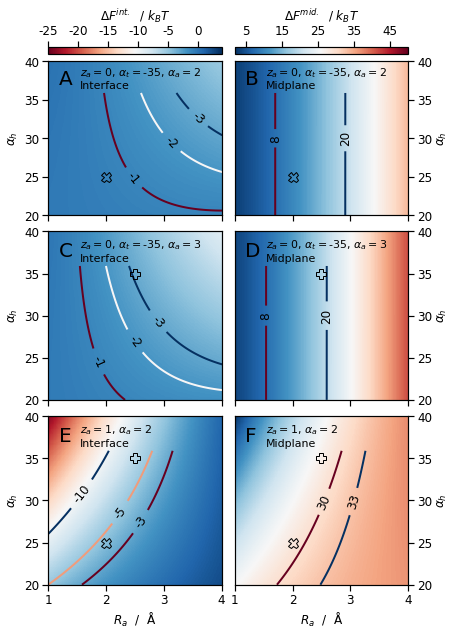

In [22]:
plt.rcParams.update({'font.size': 12,'xtick.major.pad':3,'ytick.major.pad':3,'figure.dpi':72,
                     'xtick.major.size':6,'ytick.major.size':6,'legend.fontsize':12,
                     'xtick.direction':'out','ytick.direction':'out','axes.labelsize':12,
                     'axes.linewidth':1.2,'xtick.labelsize':12,'ytick.labelsize':12,
                     'xtick.major.width':1.2, 'ytick.major.width':1.2})
plt.rcParams.update({'figure.figsize': [6.5, 9]})
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3,ncols=2)
ahs = np.arange(20,41,.1); radii = np.arange(.1,.401,.001)

vminInt=-25
vmaxInt=4
vminMid=2
vmaxMid=50

Z1 = min0(2,ahs[:,np.newaxis],-35,radii)
im1 = ax1.imshow(Z1,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminInt,vmax=vmaxInt,cmap=plt.cm.RdBu)
Z2 = max0(2,ahs[:,np.newaxis],-35,radii)
im2 = ax2.imshow(Z2,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminMid,vmax=vmaxMid,cmap=plt.cm.RdBu_r)
Z3 = min0(3,ahs[:,np.newaxis],-35,radii)
im3 = ax3.imshow(Z3,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminInt,vmax=vmaxInt,cmap=plt.cm.RdBu)
Z4= max0(3,ahs[:,np.newaxis],-35,radii)
im4 = ax4.imshow(Z4,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminMid,vmax=vmaxMid,cmap=plt.cm.RdBu_r)
Z5 = min1(2,ahs[:,np.newaxis],-35,radii)
im5 = ax5.imshow(Z5,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminInt,vmax=vmaxInt,cmap=plt.cm.RdBu)
Z6= max1(2,ahs[:,np.newaxis],-35,radii)
im6 = ax6.imshow(Z6,extent=[radii.min(),radii.max(),ahs.min(),ahs.max()],
                 origin='lower',aspect='auto',vmin=vminMid,vmax=vmaxMid,cmap=plt.cm.RdBu_r)

for Z in [Z1,Z2,Z3,Z4,Z5,Z6]:
    print(Z.min(),Z.max())

for ax in f.axes:
    ax.set_xlim(.1,.4)
    ax.set_xticks(np.arange(.1,.41,.1))
    ax.set_ylim(20,40)
    ax.set_yticks(np.arange(20,41,5))
    ax.set_yticklabels('{:1g}'.format(i) for i in np.arange(20,41,5))
    ax.set_ylabel(r'$\alpha_h$')

ax1.set_xticklabels(np.tile([''],5)); ax2.set_xticklabels(np.tile([''],5))
ax3.set_xticklabels(np.tile([''],5)); ax4.set_xticklabels(np.tile([''],5))
ax5.set_xticklabels('{:1g}'.format(i*10) for i in np.arange(.1,.41,.1))
ax6.set_xticklabels('{:1g}'.format(i*10) for i in np.arange(.1,.41,.1))
ax5.set_xlabel('$R_a$  /  Å'); ax6.set_xlabel('$R_a$  /  Å')

ax2.yaxis.set_ticks_position('right'); ax2.yaxis.set_label_position('right')
ax4.yaxis.set_ticks_position('right'); ax4.yaxis.set_label_position('right')
ax6.yaxis.set_ticks_position('right'); ax6.yaxis.set_label_position('right')

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.1)
f.add_axes(cax)
cb = f.colorbar(im1, cax=cax, orientation="horizontal", label=r'$\Delta F^{int.}$  / $k_B T$', 
                ticks=np.arange(-25,6,5))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(-25,6,5)])

divider = make_axes_locatable(ax2)
cax = divider.new_vertical(size="5%", pad=.1)
f.add_axes(cax)
cb = f.colorbar(im2, cax=cax, orientation="horizontal", label=r'$\Delta F^{mid.}$  / $k_B T$', 
                ticks=np.arange(5,51,10))
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_ticklabels(['{:1g}'.format(i) for i in np.arange(5,51,10)])

cset = ax1.contour(radii, ahs[:-50], Z1[:-50,:], [-3,-2,-1], linewidths=2,cmap=plt.cm.RdBu_r)
manual_locations = [(.34, 31),(.32, 30),(.25, 25)]
ax1.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k','k'])

cset = ax2.contour(radii, ahs[:-50], Z2[:-50,:], [8,20], linewidths=2,cmap=plt.cm.RdBu)
manual_locations = [(.17, 30),(.3, 30)]
ax2.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k'])

cset = ax3.contour(radii, ahs[:-50], Z3[:-50,:], [-3,-2,-1], linewidths=2,cmap=plt.cm.RdBu_r)
manual_locations = [(.3, 30),(.25, 27),(.2, 25)]
ax3.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k','k'])

cset = ax4.contour(radii, ahs[:-50], Z4[:-50,:], [8,20], linewidths=2,cmap=plt.cm.RdBu)
manual_locations = [(.17, 30),(.3, 30)]
ax4.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k'])

cset = ax5.contour(radii, ahs[:-50], Z5[:-50,:], [-10,-5,-3], linewidths=2,cmap=plt.cm.RdBu_r)
manual_locations = [(.17, 30),(.2, 30),(.25, 28)]
ax5.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k','k'])

cset = ax6.contour(radii, ahs[:-50], Z6[:-50,:], [30,33], linewidths=2,cmap=plt.cm.RdBu,)
manual_locations = [(.25, 30),(.3, 30)]
ax6.clabel(cset, inline=True, fmt='%1g', fontsize=12, manual=manual_locations,colors=['k','k','k'])

ax1.annotate(r'A',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax2.annotate(r'B',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax3.annotate(r'C',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax4.annotate(r'D',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax5.annotate(r'E',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax6.annotate(r'F',xy=(0.06,.85), fontsize=20, xycoords='axes fraction',color='k')
ax1.annotate(r'$z_a=0$, $\alpha_t=$-35, $\alpha_a=2$'+'\nInterface',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax2.annotate(r'$z_a=0$, $\alpha_t=$-35, $\alpha_a=2$'+'\nMidplane',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax3.annotate(r'$z_a=0$, $\alpha_t=$-35, $\alpha_a=3$'+'\nInterface',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax4.annotate(r'$z_a=0$, $\alpha_t=$-35, $\alpha_a=3$'+'\nMidplane',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax5.annotate(r'$z_a=1$, $\alpha_a=2$'+'\nInterface',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')
ax6.annotate(r'$z_a=1$, $\alpha_a=2$'+'\nMidplane',xy=(0.18,.83), fontsize=11, 
             xycoords='axes fraction',color='k')

ax1.plot( [.2], [25], 'X', ms=10, mew=1, mec='k', mfc='None')
ax2.plot( [.2], [25], 'X', ms=10, mew=1, mec='k', mfc='None')
ax5.plot( [.2], [25], 'X', ms=10, mew=1, mec='k', mfc='None')
ax6.plot( [.2], [25], 'X', ms=10, mew=1, mec='k', mfc='None')

ax3.plot( [.25], [35], 'P', ms=10, mew=1, mec='k', mfc='None')
ax4.plot( [.25], [35], 'P', ms=10, mew=1, mec='k', mfc='None')
ax5.plot( [.25], [35], 'P', ms=10, mew=1, mec='k', mfc='None')
ax6.plot( [.25], [35], 'P', ms=10, mew=1, mec='k', mfc='None')

f.tight_layout(w_pad=.1,h_pad=.2)    
f.savefig('figs/predict.pdf')
plt.show()